# Latent vector optimization

In [1]:
import os
import gc
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
from torchvision.transforms.functional import to_pil_image
import torch
import torch.nn as nn
from torch.nn import functional as F
from tqdm.notebook import tqdm
from torch import optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lpips
import json
from PIL import Image
import clip
from src.loader import Loader
from src.losses import clip_loss, id_loss, l2_loss
from src.utilities import generate_image, show_image, show_loss_plots
from IPython.display import clear_output
%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)

## Loading models

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
loader = Loader(device)
stylegan = loader.load_stylegan()
clip_model = loader.load_clip()
arcface_model = loader.load_arcface()

## Generating initial image

Setting up PyTorch plugin "bias_act_plugin"... 

/shared/vault13/users/anton_desk/study/.venv/lib/python3.9/site-packages/torch/utils/cpp_extension.py:1967: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


Done.
Setting up PyTorch plugin "filtered_lrelu_plugin"... 

/shared/vault13/users/anton_desk/study/.venv/lib/python3.9/site-packages/torch/utils/cpp_extension.py:1967: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


Done.


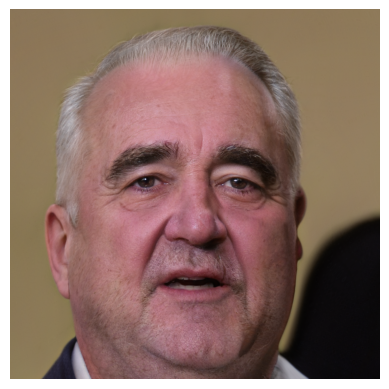

In [3]:
original_image, original_w, original_z = generate_image(stylegan, device)
torch.cuda.empty_cache()
show_image(original_image)

## W latent optimization

In [7]:
def optimize_w_latent(num_steps: int,  description: str, lr=0.1, lambda_l2 = 0.1, lambda_id = 0.1):
    losses = {
        "main" : [],
        "clip" : [],
        "l2" : [],
        "id" : []
    }
    text_features = torch.cat([clip.tokenize(description)]).to(device)
    text_features = clip_model.encode_text(text_features).to(device)
    
    w_opt: torch.Tensor = original_w.clone().to(device)
    w_opt.requires_grad = True
    optimizer = optim.AdamW([w_opt],lr,amsgrad=True)
    scheduler = optim.lr_scheduler.StepLR(optimizer,50,0.2)
    
    for step in tqdm(range(num_steps)):
        optimizer.zero_grad()
        img = ((stylegan.synthesis(w_opt) + 1) * 0.5).clamp(0,1).cpu()
        loss_clip = clip_loss(img.to(device),text_features, clip_model, device)
        loss_l2 = l2_loss(original_w.to(device), w_opt)
        loss_id = id_loss(img.to(device), original_image, arcface_model,device)
        loss = loss_clip + lambda_l2 * loss_l2 + lambda_id * loss_id

        losses["main"].append(loss.detach().item())
        losses["clip"].append(loss_clip.detach().item())
        losses["l2"].append(lambda_l2 * loss_l2.detach().item())
        losses["id"].append(lambda_id * loss_id.detach().item())
        
        loss.backward(retain_graph=True)
        optimizer.step()
        scheduler.step()
        torch.cuda.empty_cache()
        if (step + 1) % 10 == 0:  # Show image every 10 steps
            clear_output(True)
            print(f"Step: {step + 1} loss: {losses['main'][-1]}")
            show_image(img)
            plt.show()
            torch.cuda.empty_cache()
    return losses

Step: 100 loss: 0.6990290880203247


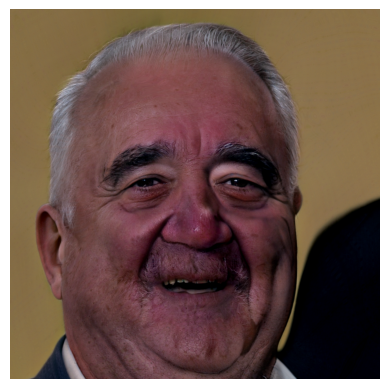

In [8]:
losses = optimize_w_latent(100, ["smile"],0.01,0.008,0.005)

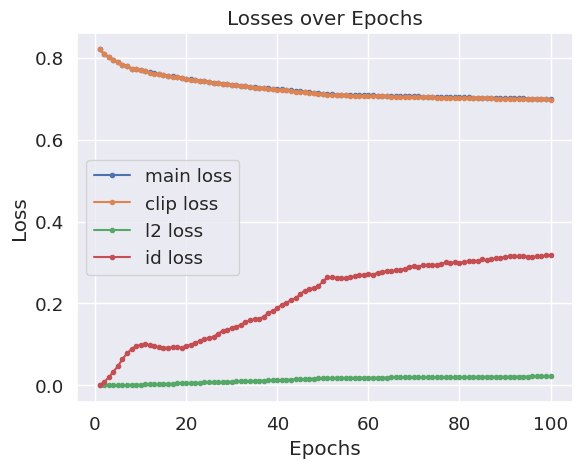

In [9]:
show_loss_plots(losses)

## Z latent optimization

In [4]:
def optimize_z_latent(num_steps: int,  description: str, lr=0.1, lambda_l2 = 0.1, lambda_id = 0.1):
    losses = {
        "main" : [],
        "clip" : [],
        "l2" : [],
        "id" : []
    }
    text_features = torch.cat([clip.tokenize(description)]).to(device)
    text_features = clip_model.encode_text(text_features).to(device)
    
    z_opt = original_z.clone().to(device)
    z_opt.requires_grad = True

    optimizer = optim.AdamW([z_opt],lr,amsgrad=True)
    scheduler = optim.lr_scheduler.StepLR(optimizer,50,0.2)
    
    for step in tqdm(range(num_steps)):
        optimizer.zero_grad()
        w_opt = stylegan.mapping(z_opt.to(device),None)
        img = ((stylegan.synthesis(w_opt) + 1) * 0.5).clamp(0,1).cpu()
        loss_clip = clip_loss(img.to(device),text_features, clip_model, device)
        loss_l2 = l2_loss(original_z.to(device), z_opt)
        loss_id = id_loss(img.to(device), original_image, arcface_model,device)
        loss = loss_clip + lambda_l2 * loss_l2 + lambda_id * loss_id

        losses["main"].append(loss.detach().item())
        losses["clip"].append(loss_clip.detach().item())
        losses["l2"].append(loss_l2.detach().item())
        losses["id"].append(loss_id.detach().item())
        
        loss.backward(retain_graph=True)
        optimizer.step()
        scheduler.step()
        if (step + 1) % 10 == 0:  # Show image every 10 epochs
            clear_output(True)
            print(f"Step: {step + 1} loss: {losses['main'][-1]}")
            show_image(img)
            plt.show()
        torch.cuda.empty_cache()
    return losses

Step: 100 loss: 0.7450303435325623


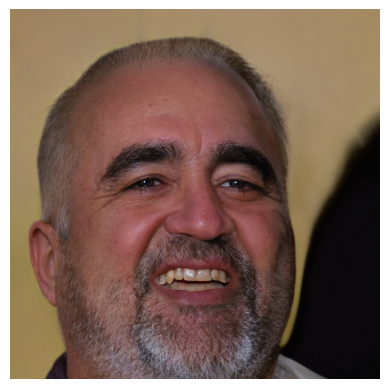

In [5]:
losses = optimize_z_latent(100, ["smile"], 0.01, 0.001, 0.005)

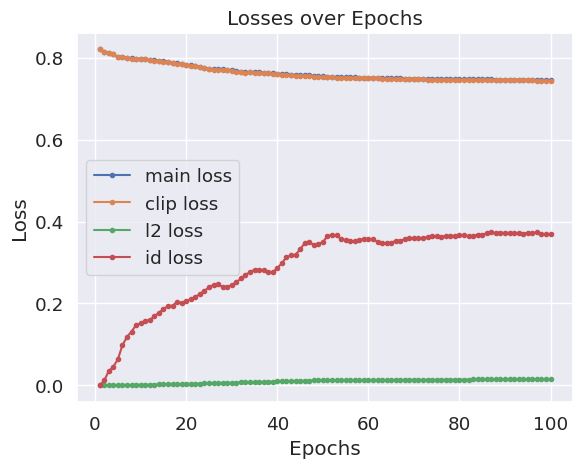

In [6]:
show_loss_plots(losses)